# Autofig Basics

``autofig`` aims to provide the following: 
* a unified calling structure to matplotlib's [plot](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.plot.html), [scatter](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.scatter.html), [errorbar](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.errorbar.html), [LineCollection](http://matplotlib.org/gallery/shapes_and_collections/line_collection.html), and [PolyCollection](http://matplotlib.org/api/collections_api.html#matplotlib.collections.PolyCollection) in both 2D and 3D projections.  So if you decide you want to add errorbars or colorscaling to an existing plot call, you don't need to change the entire calling structure anymore.
* basic "3D" support within 2D figures (by providing the z-coordinate, the z-orders will automatically be set)
* a high-level wrapper to animate an existing plot over some independent-variable (i.e. time), with effects including highlight and uncover.
* intelligent options for axes limits within animations.
* intelligent defaults for subplot creation based on conflicts in units/labels.

In [1]:
import autofig
import numpy as np
import astropy.units as u

``autofig`` allows building figures both with a top-down syntax (similar to calling plt.plot(...)) or with an object-oriented bottom-up syntax (similar to fig=plt.figure(); ax=fig.add_subplot(...); ax.plot(...)).  To get started, we'll use the top-down approach.

Using the top-down syntax there is really only one main call, autofig.plot.  This accepts arrays for each of 6 dimensions (optionally).  These dimensions are:
* x
* y
* z (will be used for z-order in 2D plots)
* i (the independent variable - either 'x', 'y', 'z' or its own array)
* c (color)
* s (size)

Let's start with a basic plot with just x and y data.

In [2]:
x = np.linspace(0,1,101)
y = np.random.rand(101)

By using the top-down syntax and not creating any objects, ``autofig`` will continue to "append" to the existing figure.  In order to start over and clear the figure and all previous commands, we'll call ``autofig.reset``.  We'll see later other ways to get around this.

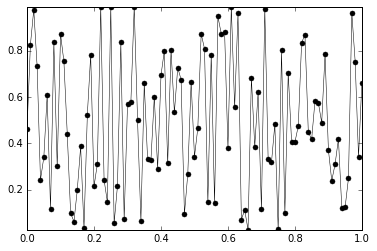

In [3]:
autofig.reset()
autofig.plot(x=x, y=y)

## Labels and Units

In addition, each of the dimensions accept the following optional suffixes:
* unit (the units of the provided array, either string or astropy.units object)
* error (an array with same length as the values, not accepted for 'c' or 's')
* label

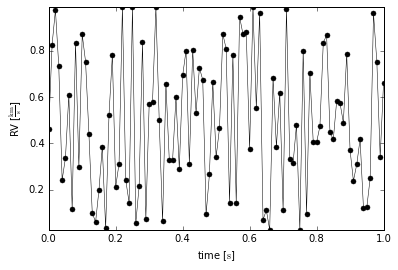

In [4]:
autofig.reset()
autofig.plot(x=x, xlabel='time', xunit=u.s, y=y, ylabel='RV', yunit='km/s')

Here we can see that the drawn label is actually the provided label AND the units.

## Styling (Markers and Lines)

``autofig.plot`` also accepts the following matplotlib keyword arguments:
* marker
* linestyle/ls

Note that markersize/ms and linewidth/lw are rejected with an error - these should be sent via the 's' dimension.  Similarly, color should be sent via the 'c' dimension.

In each of these cases, if both are provided, the fully spelled-out argument gets priority.

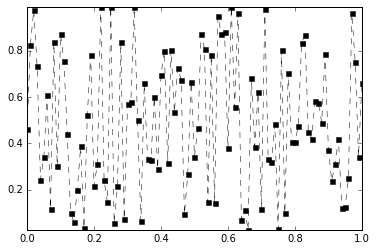

In [5]:
autofig.reset()
autofig.plot(x=x, y=y, marker='s', ls='dashed')

## Errorbars

Adding errorbars is as simple as providing an array to the error suffix for a given dimension.

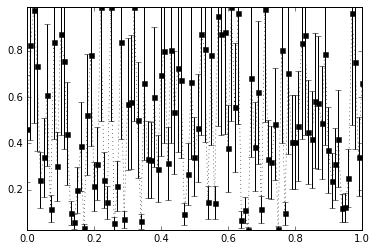

In [6]:
autofig.reset()
autofig.plot(x=x, y=y, yerror=y/2, marker='s', ls='dotted')

## Color

Since 'c' is one of the dimensions, it accepts either an array or a string representing the color to pass on to matplotlib.  Note that it affects both the markers and the lines.  

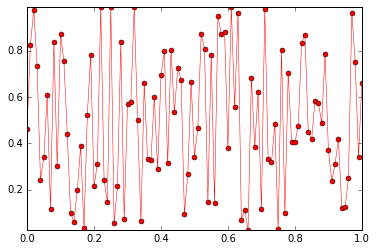

In [7]:
autofig.reset()
autofig.plot(x=x, y=y, c='red')

If you want different color treatment for markers and lines you must do so with two separate calls to plot.

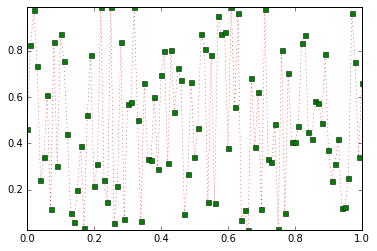

In [8]:
autofig.reset()
autofig.plot(x=x, y=y, marker='None', ls='dotted', c='red')
autofig.plot(x=x, y=y, marker='s', ls='None', c='green')

Now let's pass an array to the color dimension, as it is a dimension it also accepts label and unit.

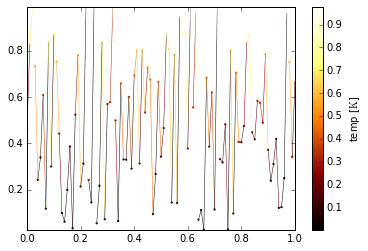

In [9]:
c = y**2

autofig.reset()
autofig.plot(x=x, y=y, 
             c=c, clabel='temp', cunit=u.K, cmap='afmhot')

Colorscales and colorbars will be shared (per-axes) whenever there is no conflict between the 'c' dimension's label, units, and colormap.

**BUG:** this used to show both colorbars... I need to fix that

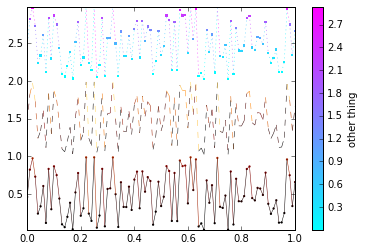

In [10]:
autofig.reset()
autofig.plot(x=x, y=y, c=c, clabel='temp', cunit=u.K, cmap='afmhot')
autofig.plot(x=x, y=y+1, c=2*c, clabel='temp', cunit=u.K, cmap='afmhot')
autofig.plot(x=x, y=y+2, c=3*c, clabel='other thing', cmap='cool')

## Size

Since 's' is also a dimension, it accepts either an array or float represent the markersizes and linewidths.

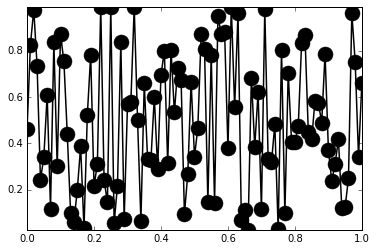

In [11]:
autofig.reset()
autofig.plot(x=x, y=y, s=3)

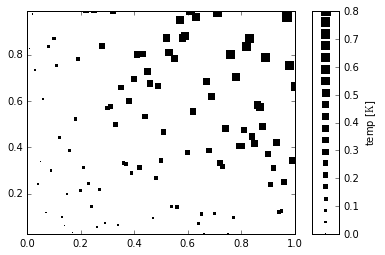

In [12]:
s = np.sin(x*y)

autofig.reset()
autofig.plot(x=x, y=y,
             s=s, slabel='temp', sunit='K', 
             marker='s', ls='None')

Similarly to cmap, when scaling by size you can pass a tuple to smap.  This tuple will give the lower and upper bounds of the point sizes that the entire range will be mapped onto.  By default this is (1,100), but if we want a larger range of sizes, for example, we could do the following:

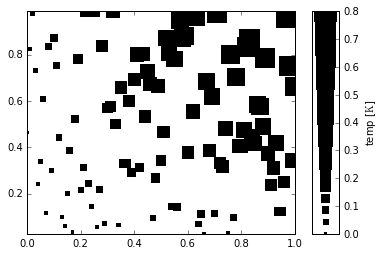

In [13]:
s = np.sin(x*y)

autofig.reset()
autofig.plot(x=x, y=y,
             s=s, slabel='temp', sunit='K', smap=(10,500),
             marker='s', ls='None')

We can also have the size dimension handle linewidths:

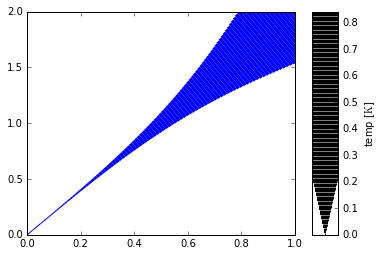

In [15]:
s = np.sin(x**3)

autofig.reset()
autofig.plot(x=x, y=2*x,
             s=s, slabel='temp', sunit='K', 
             c='blue', marker='None', ls='solid')

## Property Cycler

As you may have noticed, `autofig` attempts to set reasonable defaults for all properties (color, linestyle, marker, etc) when no value is provided (or None is sent).

Sending None to linestyle or marker will fallback on the defaults (provided by the property cycler), whereas the strings 'None' or 'none' will result in no line or marker drawn, respectively.

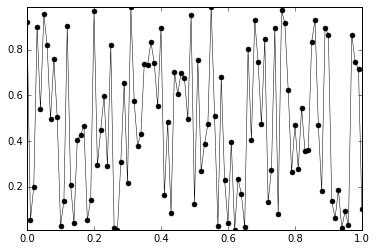

In [16]:
autofig.reset()
autofig.plot(x=x, y=y, linestyle=None)

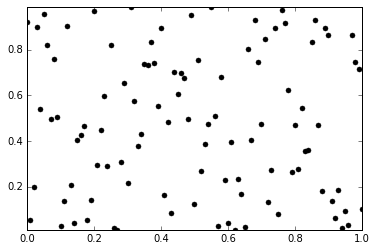

In [17]:
autofig.reset()
autofig.plot(x=x, y=y, linestyle='None')

When multiple calls are made, Nones are replaced with the next available entry from the cycler, which is handled on a per-axes (not per-figure) basis.

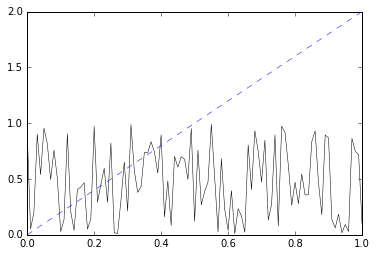

In [18]:
autofig.reset()
autofig.plot(x=x, y=y, marker='None')
autofig.plot(x=x, y=2*x, marker='None')

In the case above, where no color or linestyle were provided for either call to plot, both followed the order of their respective cyclers (black -> blue for color and solid -> dashed for linestyle).

If we set the color on the first call to be red, the second will default to black since it is unused.

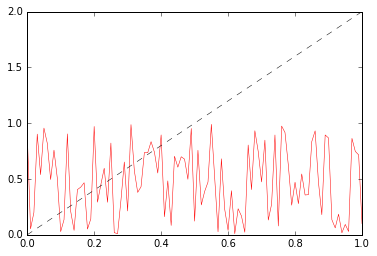

In [19]:
autofig.reset()
autofig.plot(x=x, y=y, marker='None', c='red')
autofig.plot(x=x, y=2*x, marker='None')

And lastly, by setting the second to black the first will need to change to the second color in the cycler.  Note that it originally starts as black, but since the color is set to None, it will change when the second call is added.

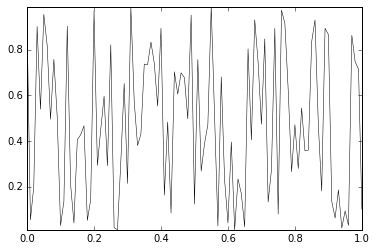

In [20]:
autofig.reset()
autofig.plot(x=x, y=y, marker='None')

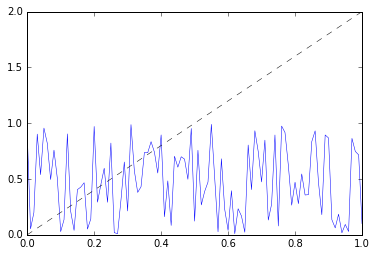

In [21]:
autofig.plot(x=x, y=2*x, marker='None', color='k')

## Independent Variable

By defining the independent variable, we can draw our figure at a given value of that variable.

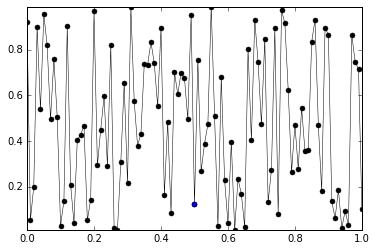

In [22]:
autofig.reset()
autofig.plot(x=x, y=y, i='x')
autofig.draw(i=0.5)

Here we can see a black dot drawn highlighting the value at i=0.5.

There are several available effects for the independent variable which accept the corresponding additional arguments:
* highlight: highlight_marker, highlight_color, highlight_size
* uncover

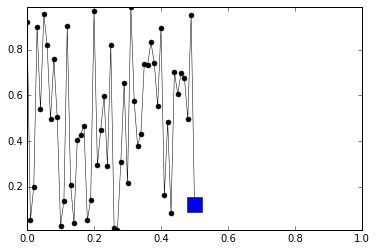

In [23]:
autofig.reset()
autofig.plot(x=x, y=y, i='x', 
             uncover=True,
             highlight=True, highlight_color='b', highlight_marker='s', highlight_size=3)
autofig.draw(i=0.5)

## Limits

As can be seen above, by default axes limits are set to encompass *all* of the data (ignoring the hidden data if uncover=True) and without any padding.

**[There currently isn't a nice high-level way to set fixed_limits to False, so I'll leave that out for now]**

Padding can be done in general or per-dimension.  If a value is provided for a given dimension, it will take priority over the default value applied to the axes.  For example:

**[There currently isn't a nice high-level way of adjusting padding either... ]**

## Animations

Creating an animation is as simple as calling ``animate`` instead of ``draw`` and passing a list of values to loop over for the independent variable (interpolation will be used, so they don't need to be a member of the original data array).

**NOTE: I don't like how everywhere else we use i, but here we use indeps... I may have to switch i out everywhere else (can't use is for obvious reasons)**

In [24]:
autofig.reset()
autofig.plot(x=x, y=y, i='x', uncover=True)
autofig.animate(indeps=np.linspace(0,1,201))

/usr/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In some cases the independent variable may not be one of the plotted dimensions (time, for example).

In [25]:
t = np.linspace(0, 2*np.pi, 101)
x = np.cos(t)
y = np.sin(t)
c = x*y

autofig.reset()
autofig.plot(x=x, y=y, i=t, c=c, clabel='x*y',
             marker='None', uncover=True)
autofig.animate(indeps=t)

## Subplots

When making calls to plot, ``autofig`` determines whether that call is consistent with any of the existing axes/subplots.  If not, it creates a new one and handles the subplot grid accordingly.

A plot is *inconsistent* with an existing axes if any of the following conditions is True:
* non-identical label in any *cartesian* or independent-variable (x,y,z,i) dimension (with None or omitted labels ignored)
* inconsistent (different physical type) units in any *cartesian* or independent-variable (x,y,z,i) dimension (None or omitted is assumed to be unitless and can therefore cause inconsistency)

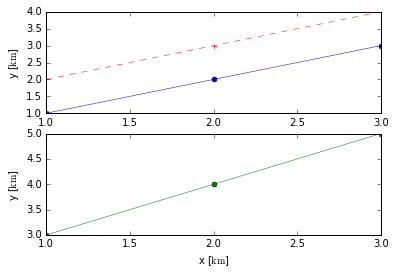

In [26]:
autofig.reset()
autofig.plot(x=[1,2,3], xunit='s', xlabel='time',
             y=[1,2,3], yunit='km', ylabel='y',
             color='blue')
autofig.plot(x=[1,2,3], xunit='s',
             y=[2,3,4], yunit='km',
             color='red')
autofig.plot(x=[1,2,3], xunit='km', xlabel='x',
             y=[3,4,5], yunit='km', ylabel='y',
             color='green')